# Generates images from text prompts.

By Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings). It uses a 602M parameter diffusion model trained on Conceptual 12M. See the GitHub repo for more information: https://github.com/crowsonkb/v-diffusion-pytorch.

In [1]:
# @title Licensed under the MIT License

# Copyright (c) 2022 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [2]:
# Check the GPU

!nvidia-smi

Tue Jan 11 06:11:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:67:00.0 Off |                  N/A |
|  0%   54C    P8    20W / 250W |   5880MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install dependencies (no need to rerun this section if you restart the notebook runtime)

In [3]:
# Install dependencies

!apt install git curl -y

%pip install ftfy regex requests tqdm
!git clone --recursive https://github.com/crowsonkb/v-diffusion-pytorch

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.58.0-2ubuntu3.16).
git is already the newest version (1:2.17.1-1ubuntu0.9).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.
Note: you may need to restart the kernel to use updated packages.
fatal: destination path 'v-diffusion-pytorch' already exists and is not an empty directory.


In [4]:
# Download the diffusion model
# SHA-256: 4fc95ee1b3205a3f7422a07746383776e1dbc367eaf06a5b658ad351e77b7bda

!mkdir v-diffusion-pytorch/checkpoints
# !curl -L https://v-diffusion.s3.us-west-2.amazonaws.com/cc12m_1_cfg.pth > v-diffusion-pytorch/checkpoints/cc12m_1_cfg.pth

mkdir: cannot create directory ‘v-diffusion-pytorch/checkpoints’: File exists


### Import modules and load models

In [5]:
# Imports

import gc
import math
import sys

from IPython import display
import torch
from torchvision import utils as tv_utils
from torchvision import transforms
from tqdm.notebook import trange, tqdm

sys.path.append('./v-diffusion-pytorch')

from CLIP import clip
from diffusion import get_model, sampling, utils

from PIL import Image

In [6]:
# Load the models

model = get_model('cc12m_1_cfg')()
_, side_y, side_x = model.shape
model.load_state_dict(torch.load('v-diffusion-pytorch/checkpoints/cc12m_1_cfg.pth', map_location='cpu'))
model = model.half().cuda().eval().requires_grad_(False)
clip_model = clip.load(model.clip_model, jit=False, device='cpu')[0]

In [157]:
@torch.no_grad()
def sample(model, x, steps, eta, extra_args, callback=None, pred=None, eps=None):
    """Draws samples from a model given starting noise."""
    ts = x.new_ones([x.shape[0]])

    # Create the noise schedule
    alphas, sigmas = utils.t_to_alpha_sigma(steps)

    # The sampling loop
    for i in trange(len(steps)):

        if (pred == None or i != 0):
            # Get the model output (v, the predicted velocity)
            with torch.cuda.amp.autocast():
                v = model(x, ts * steps[i], **extra_args).float()
                
            # Predict the noise and the denoised image
            pred = x * alphas[i] - v * sigmas[i]
            eps = x * sigmas[i] + v * alphas[i]

            # Call the callback
            if callback is not None:
                callback({'x': x, 'i': i, 't': steps[i], 'v': v, 'pred': pred})

        # if (steps[i] < 0.5 and pred.size() == torch.Size([1, 3, 256, 256])):
        #     pred = transforms.Resize((side_y*2, side_x*2))(pred)
        #     eps = torch.randn([1, 3, side_y*2, side_x*2], device='cuda')

        # If we are not on the last timestep, compute the noisy image for the
        # next timestep.
        if i < len(steps) - 1:
            # If eta > 0, adjust the scaling factor for the predicted noise
            # downward according to the amount of additional noise to add
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            # Recombine the predicted noise and predicted denoised image in the
            # correct proportions for the next step
            x = pred * alphas[i + 1] + eps * adjusted_sigma

            # Add the correct amount of fresh noise
            if eta:
                x += torch.randn_like(x) * ddim_sigma

    # If we are on the last timestep, output the denoised image
    display_image(pred)
    return pred

sampling.sample = sample

In [158]:

defaults = {
    'weight': 5,
    'n_images': 1,
    'steps': 50,
    'eta': 1,
    'seed': 1,
    'display_every': 10,
    'side_x': 256,
    'side_y': 256,
}

batches = [
    {
        'prompt': 'cyberpunk city, high resolution',
        'name': 'cyberpunk_city',
    },
]

### Actually do the run...

Generating cyberpunk_city.png


  0%|          | 0/50 [00:00<?, ?it/s]

Step 0 of 50:


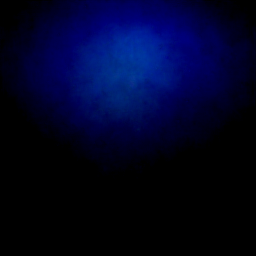


Step 10 of 50:


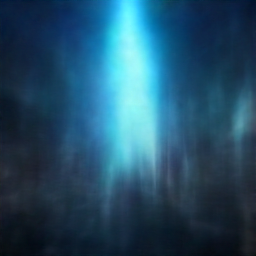


Step 20 of 50:


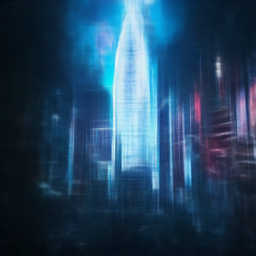


Step 30 of 50:


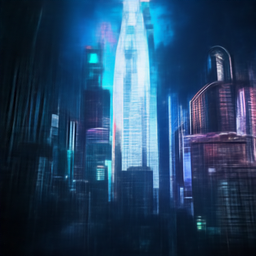


Step 40 of 50:


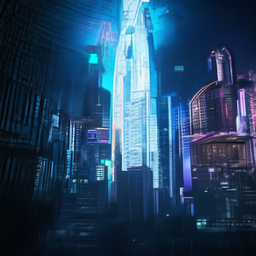

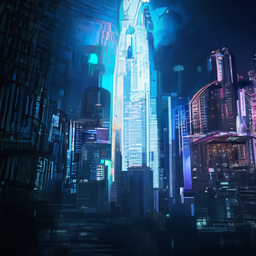

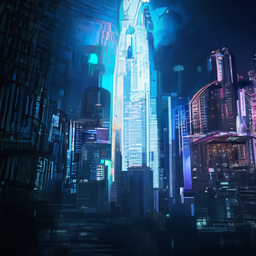

  0%|          | 0/50 [00:00<?, ?it/s]

Step 10 of 50:


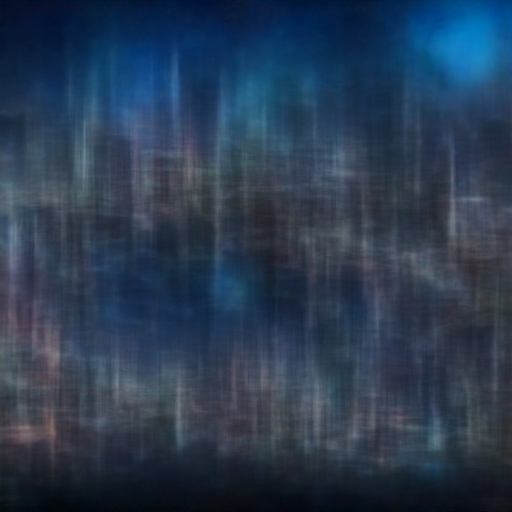


Step 20 of 50:


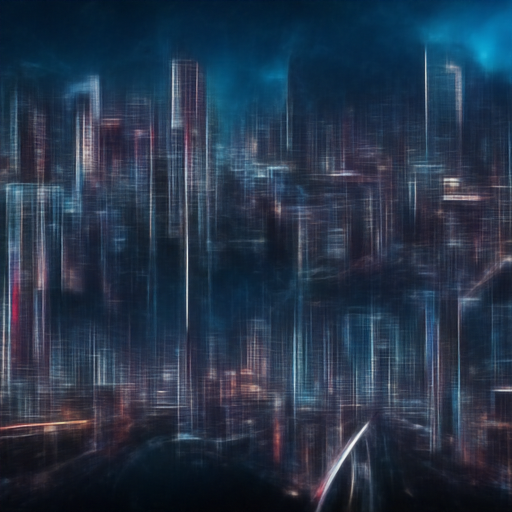

KeyboardInterrupt: 

In [160]:
def cfg_model_fn(x, t):
    """The CFG wrapper function."""
    n = x.shape[0]
    x_in = x.repeat([2, 1, 1, 1])
    t_in = t.repeat([2])
    clip_embed_repeat = target_embed.repeat([n, 1])
    clip_embed_in = torch.cat([torch.zeros_like(clip_embed_repeat), clip_embed_repeat])
    v_uncond, v_cond = model(x_in, t_in, clip_embed_in).chunk(2, dim=0)
    v = v_uncond + (v_cond - v_uncond) * weight
    return v


def display_callback(info):
    if display_every is None: return
    if info['i'] % display_every != 0: return

    nrow = math.ceil(info['pred'].shape[0]**0.5)
    grid = tv_utils.make_grid(info['pred'], nrow, padding=0)
    tqdm.write(f'Step {info["i"]} of {steps}:')
    display.display(utils.to_pil_image(grid))
    tqdm.write(f'')


def run():
    gc.collect()
    torch.cuda.empty_cache()
    torch.manual_seed(current_seed)

    x = torch.randn([1, 3, side_y, side_x], device='cuda')
    t = torch.linspace(1, 0, steps + 1, device='cuda')[:-1]
    step_list = utils.get_spliced_ddpm_cosine_schedule(t)
    outs = sampling.sample(cfg_model_fn, x, step_list, eta, {}, callback=display_callback)
    display_image(outs, True)

    pred = transforms.Resize((side_y*2, side_x*2))(outs)
    # step_list = utils.get_spliced_ddpm_cosine_schedule(t)
    # alphas, sigmas = utils.t_to_alpha_sigma(step_list)
    eps = torch.randn([1, 3, side_y*2, side_x*2], device='cuda')
    # outs = outs * alphas[25] + eps * sigmas[25]
    t = torch.linspace(0.1, 0, steps + 1, device='cuda')[:-1]
    outs = sampling.sample(cfg_model_fn, pred, step_list, eta, {}, callback=display_callback, pred=pred, eps=eps)
    # display_image(outs, True)
    
    tqdm.write('Done!')


def display_image(outs, save=False):
    for i, out in enumerate(outs):
        pil_image = utils.to_pil_image(out)
        display.display(pil_image)
        if save: pil_image.save(filename)


for batch in batches:
    prompt = batch.get('prompt') or defaults['prompt']
    weight = batch.get('weight') or defaults['weight']
    n_images = batch.get('n_images') or defaults['n_images']
    eta = batch.get('eta') or defaults['eta']
    seed = batch.get('seed') or defaults['seed']
    steps = batch.get('steps') or defaults['steps']
    side_x = batch.get('side_x') or defaults['side_x']
    side_y = batch.get('side_y') or defaults['side_y']
    display_every = batch.get('display_every') or defaults['display_every']

    target_embed = clip_model.encode_text(clip.tokenize(prompt)).float().cuda()
    for i in range(n_images):
        n = '' if i == 0 else f'_{i}'
        filename = f'{batch["name"]}{n}.png'
        current_seed = seed + i
        print(f'Generating {filename}')
        run()